In [1]:
# visulize the convergance of the numerical method

import sys
import petsc4py

petsc4py.init(sys.argv)

%pylab inline
pylab.rcParams['figure.figsize'] = (18.5, 10.5)

import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{mathtools, bm}"]

import numpy as np
import pandas as pd
from src import stokes_flow as sf
from src.StokesFlowMethod import *
from petsc4py import PETSc
import os
import re
import glob
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scanf import scanf
from io import StringIO
from codeStore import support_fun as spf

PWD = os.getcwd()
fontsize = 40
np.set_printoptions(linewidth=110, precision=5)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# for the paper m2, test the relative error between numerical and analytical values of uz
mat_contents = loadmat('convergence_z.mat')
b = mat_contents['b'][0][0]
# b = 0.8
z1 = mat_contents['z1'][0]
IDX = z1 > 0.013
z1 = z1[IDX]
R1 = mat_contents['R1'][0][IDX]
phi1 = mat_contents['phi1'][0][IDX]
uz = mat_contents['u_struct'][0][-1][3][0][IDX]
nodes = np.vstack((R1 * np.cos(phi1), R1 * np.sin(phi1), z1)).T

# velocity (stokeslets) in infinite space
m = light_stokeslets_matrix_3d(nodes, np.array((b, 0, 0)))
uz_inf = np.dot(m, (0, 0, 1))[2::3]

fileHeadle = 'R09l20'
problem_kwargs = {
    'name':                        'force_pipe',
    'matrix_method':               'pf_stokesletsInPipe',
    'dp':                          -1,
    'ep':                          -1,
    'lp':                          -1,
    'rp':                          1,
    'b0':                          -1,
    'b1':                          -1,
    'nb':                          -1,
    'th':                          -1,
    'stokesletsInPipe_pipeFactor': -1,
    'solve_method':                'gmres',
    'precondition_method':         'none',
    'fileHeadle':                  fileHeadle,
    'check_acc':                   1,
    'plot_geo':                    0,
    'MPISIZE':                     0,
    'ffweightx':                   1,
    'ffweighty':                   1,
    'ffweightz':                   1,
    'ffweightT':                   1,
    'zoom_factor':                 1,
}
# velocity (stokeslets) in pipe 
problem = sf.stokesletsInPipeforcefreeProblem(**problem_kwargs)
problem.set_prepare(fileHeadle)
_, _, num_ans3 = problem.debug_solve_stokeslets_b(b=b, node=nodes)
num_uz = num_ans3.getArray().reshape((-1, 3))[:, 2]

# print('analytical, numerical, abs_err, relative_err')
# print(np.vstack((z1, uz, num_uz, num_uz - uz, (num_uz - uz) / uz)).T)

In [3]:
# check convergence1

# get data 1
dir_name1 = 'test_L_ds'
dir_name2 = 'case_use'
t_dir = os.path.join(PWD, dir_name1, dir_name2)
mat_list = glob.glob('%s/case?_L*_ds*_check_b*_u.mat' % t_dir)

L = []             # pipe length
ds = []            # delta length
b_list = []        # location of x_f
threshold = []     # cut of threshold
errx = []          # error of velocity
erry = []          # error of velocity
errz = []          # error of velocity
errx1 = []          # error of velocity
erry1 = []          # error of velocity
errz1 = []          # error of velocity
nnode = []         # amount of nodes

for mati in mat_list:
    mat_contents = loadmat(mati)
    kwargs = mat_contents['kwargs'][0, 0]
    _, Li, dsi, bi = scanf('case%d_L%f_ds%f_check_b%f_u.mat', os.path.basename(mati))
    cthi = kwargs['th'][0]
    u11_ana = mat_contents['u11_ana']
    u21_ana = mat_contents['u21_ana']
    u31_ana = mat_contents['u31_ana']
    u11_num = mat_contents['u11_num']
    u21_num = mat_contents['u21_num']
    u31_num = mat_contents['u31_num']
    ni = u11_ana.size
    errxi = np.linalg.norm(u11_ana - u11_num) / ni
    erryi = np.linalg.norm(u21_ana - u21_num) / ni
    errzi = np.linalg.norm(u31_ana - u31_num) / ni
    errxi1 = np.sqrt(np.sum((u11_ana - u11_num) ** 2) / np.sum(u11_ana ** 2)) / ni
    erryi1 = np.sqrt(np.sum((u21_ana - u21_num) ** 2) / np.sum(u21_ana ** 2)) / ni
    errzi1 = np.sqrt(np.sum((u31_ana - u31_num) ** 2) / np.sum(u31_ana ** 2)) / ni
    
    L.append(Li)
    ds.append(dsi)
    b_list.append(bi)
    threshold.append(cthi)
    errx.append(errxi)
    erry.append(erryi)
    errz.append(errzi)
    errx1.append(errxi1)
    erry1.append(erryi1)
    errz1.append(errzi1)
    
data_err = pd.DataFrame({'L': np.hstack(L), 
                         'ds': np.hstack(ds), 
                         'b': np.hstack(b_list), 
                         'cth': np.hstack(threshold),
                         'errx': np.hstack(errx), 
                         'erry': np.hstack(erry), 
                         'errz': np.hstack(errz), 
                         'errx1': np.hstack(errx1), 
                         'erry1': np.hstack(erry1), 
                         'errz1': np.hstack(errz1), })\
               .pivot_table(index=['L', 'ds'], columns=['b'])
errx = data_err.errx
erry = data_err.erry
errz = data_err.errz
errx1 = data_err.errx1
erry1 = data_err.erry1
errz1 = data_err.errz1

# get data 2
txt_names = glob.glob('%s/*.txt' % t_dir)
L = []             # pipe length
ds = []            # delta length
nnode = []         # amount of nodes
threshold = []     # cut of threshold

for txt_name in txt_names:
    with open(txt_name, 'r') as ftxt:
        FILE_DATA = ftxt.read()
    
    text_headle = 'pipe length:'
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    L.append(temp1)
    
    text_headle = 'delta length, epsilon and factor of pipe are'
    temp2 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    ds.append(temp2)
    
    text_headle = 'Stokeslets in pipe prepare, contain '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    nnode.append(temp1)
    
    text_headle = 'threshold of series is '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    threshold.append(temp1)

data_detail = pd.DataFrame({'L': np.hstack(L), 
                    'ds': np.hstack(ds), 
                    'nnode': np.hstack(nnode), 
                    'cth': np.hstack(threshold), })\
        .pivot_table(index=['L', 'ds'])
nnode = data_detail.nnode


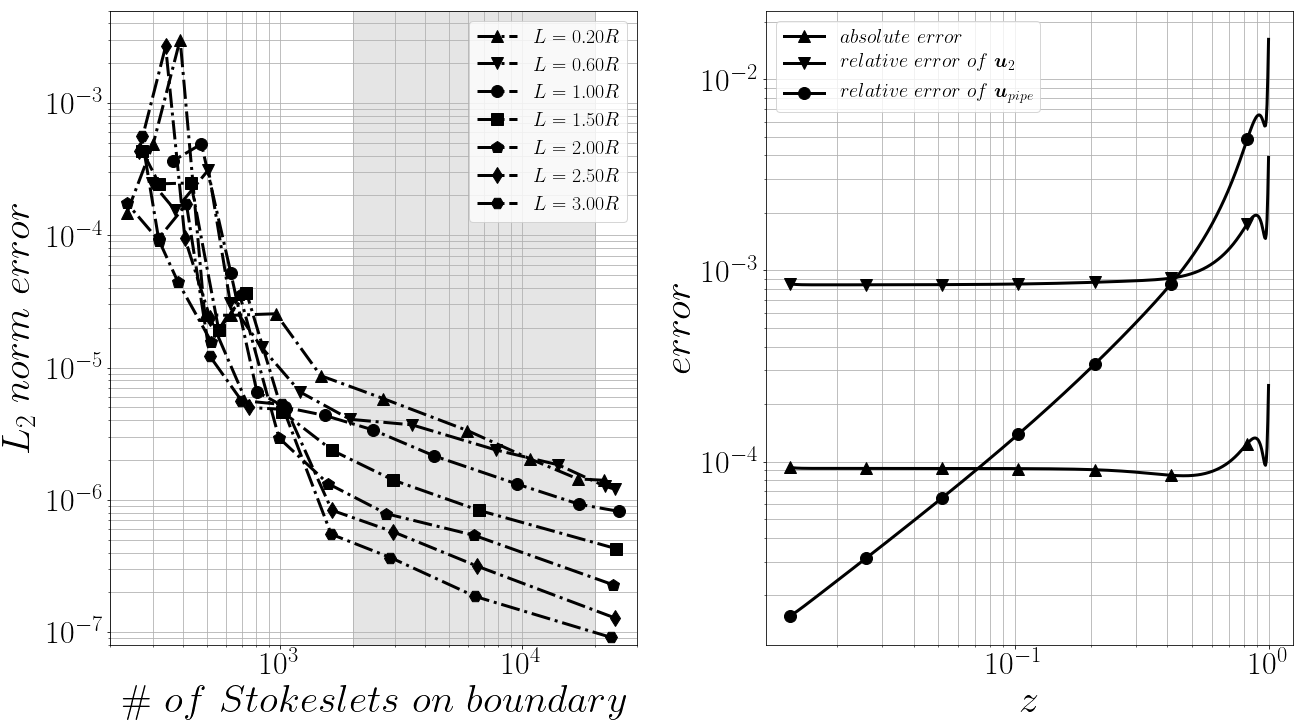

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 2)
ax2 = fig.add_subplot(1, 2, 1)
# ax3 = ax2.twinx()
rel_err1 = np.abs((num_uz - uz) / uz)
rel_err2 = np.abs((num_uz - uz) / (uz - uz_inf))
rel_err3 = np.abs(num_uz - uz)
# rel_err = np.abs((num_uz - uz) / uz)
# rel_err2 = np.abs((num_uz - uz))
# rel_err2 = np.abs(uz - uz_inf)

ax1.loglog(z1, rel_err3, '^-', linewidth=3, label='$absolute\ error$', color='k', ms=fontsize*0.3, markevery=100)
ax1.loglog(z1, rel_err2, 'v-', linewidth=3, label='$relative\ error\ of\ \\bm{u}_{2}', color='k', ms=fontsize*0.3, markevery=100)
ax1.loglog(z1, rel_err1, 'o-', linewidth=3, label='$relative\ error\ of\ \\bm{u}_{pipe}$', color='k', ms=fontsize*0.3, markevery=100)
ax1.legend(fontsize=fontsize*0.5, loc=2)
ax1.set_xlabel('$z$', size=fontsize)
ax1.set_ylabel('$error$', size=fontsize)
# ax1.set_xlim(0.01, 1.2)
# ax1.set_ylim(1e-5, 3e-2)
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()

# # nnode-err
# bi = errx.columns[[5]].values
# t1 = errx[bi]
# for Li in t1.index.levels[0][1:]:
#     ty = t1.loc[Li].values.T[0]
#     tx = data_detail.loc[Li].nnode.values
#     ax2.loglog(tx, ty, '*-.', label='L=%.2f' % Li, linewidth=3)
# #     print(np.isfinite(tx) & np.isfinite(ty))
# #     print()
#     spf.fit_power_law(ax2, tx, ty, 2000, 10**4, linestyle='-', linewidth=5)
# # ax2.set_title('b=%f' % bi)
# ax2.legend()
# ax2.set_xlabel('$dof$', size=fontsize)
# ax2.set_ylabel('$err$', size=fontsize)
# # ax2.set_xlim(0.02, 0.3)
# ax2.set_ylim(10**-2, 10**2)
# xticks = (100, 1000, 10000, )
# ax2.xaxis.set_ticks(xticks)
# ax2.xaxis.set_ticklabels(xticks)
# # ax2.loglog((0.03, 0.1), (0.003, 10**((np.log10(0.1 / 0.03))*1.5 + np.log10(0.003))), 'b-', linewidth=5)
# plt.sca(ax2)
# plt.xticks(fontsize=fontsize*0.8)
# plt.yticks(fontsize=fontsize*0.8)
# plt.tight_layout()

# 1/ds-err
bi = errx.columns[[5]].values
t0 = errx[bi]
t1 = errx1[bi]
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'p-.', 'd-.', 'H-.']
for Li, lsi in zip(t0.index.levels[0], linestyle_list):
    ty = t0.loc[Li]
#     tx = 1 / ty.index
    tx = data_detail.loc[Li].nnode.values
    ty = t0.loc[Li].values.T[0]
    ty1 = t1.loc[Li].values.T[0]
    ax2.loglog(tx, ty, lsi, label='$L=%.2fR$' % Li, linewidth=3, ms=fontsize*0.3, color='k')
#     ax3.loglog(tx, ty1, '*-.', label='L=%.2f' % Li, linewidth=3)
#     spf.fit_power_law(ax2, tx, ty, 2000, 20000, linestyle='-', linewidth=5)
ax2.legend(fontsize=fontsize*0.5, loc=0)
ax2.set_xlabel('$\#\ of\ Stokeslets\ on\ boundary$', size=fontsize)
ax2.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax2.set_xlim(2e2, 3e4)
# # ax2.set_ylim(1e-2, 1e2)
# # ax2.loglog((15, 40), (1e-5, 10**((np.log10(15 / 40))*1.3 + np.log10(1e-5))), 'k-', linewidth=5)
# # ax2.loglog((13, 35), (2e-6, 10**((np.log10(13 / 35))*1.3 + np.log10(2e-6))), 'k-', linewidth=5)
# xticks = np.array([2e2, 1e3, 1e4, 3e4])
# ax2.xaxis.set_ticks(xticks)
# ax2.xaxis.set_ticklabels(xticks)
tylim = (8e-8, 0.005)
ax2.fill_between(np.array((2000, 20000)), *tylim, color='k', alpha=0.1)
ax2.set_ylim(tylim)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()


y = -133.256722 + 19355.557677 * x in range (0, 2)
slope=0.518534 in range (100, 3000)


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


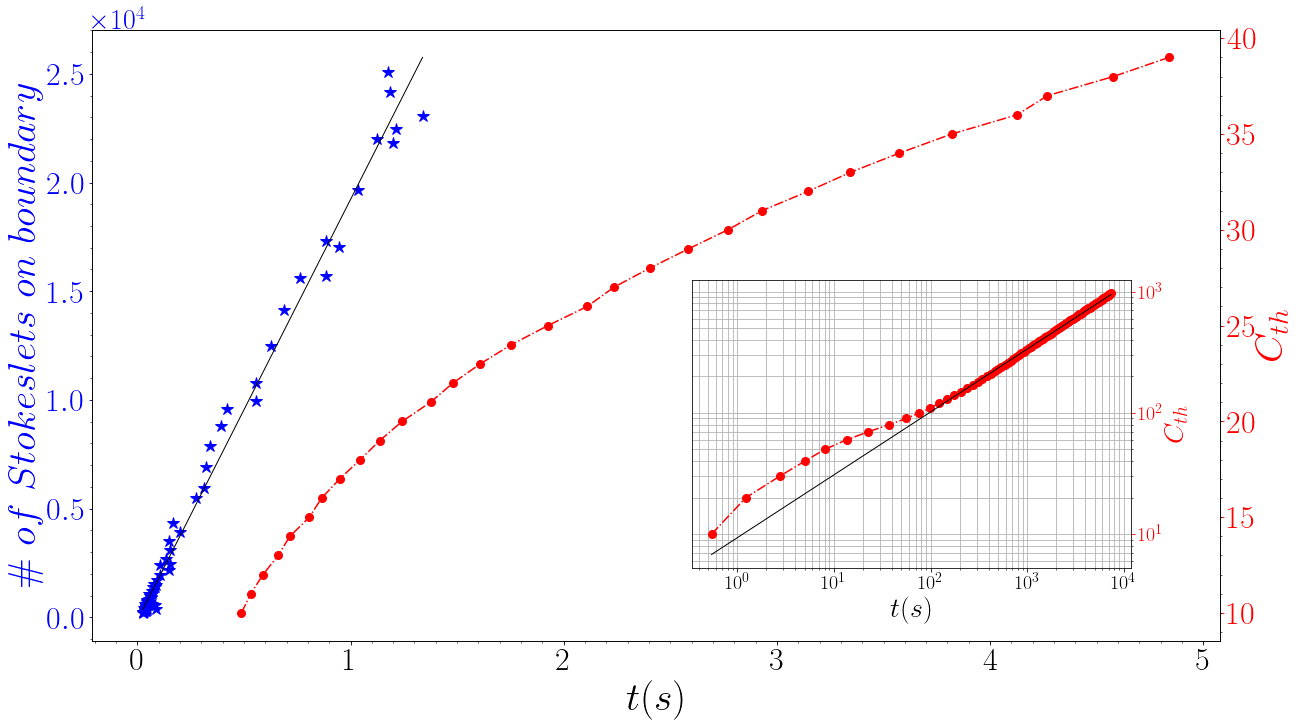

In [6]:
# speed of numerical and analytical methods
mat_contents = loadmat('num_ana_speed.mat')
dt_all = mat_contents['dt_all'].T[0]
dt_ana = mat_contents['dt_ana'].T[0]
dt_num = mat_contents['dt_num'].T[0]
cth_all = mat_contents['cth_all'].T[0]
cth = mat_contents['cth'].T[0]
nnode = mat_contents['nnode'].T[0]
idx = dt_ana < 5
dt_ana = dt_ana[idx]
cth = cth[idx]

fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax3 = plt.axes([.53, .23, .33, .38])

ax1.plot(dt_num, nnode, 'b*', ms=fontsize*0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.tick_params('y', colors='b')
spf.fit_line(ax1, dt_num, nnode, 0, 2, ifprint=1, linestyle='-', linewidth=1)
ax1.set_xlabel('$t(s)$', size=fontsize)
ax1.set_ylabel('$\#\ of\ Stokeslets\ on\ boundary$', size=fontsize, color='b')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.yaxis.get_offset_text().set_fontsize(fontsize*0.7)
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(1000))
# ax1.tick_params(axis='y', length=10, width=5)               
ax2.plot(dt_ana, cth, 'r.-.', ms=fontsize*0.4)
ax2.tick_params('y', colors='r')
ax2.set_ylabel('$C_{th}$', size=fontsize, color='r')
ax2.yaxis.set_minor_locator(MultipleLocator(1))
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
# plt.grid(True, which='both')
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
# plt.grid(True, which='both')
plt.tight_layout()

ax3.loglog(dt_all, cth_all, 'r.-.', ms=fontsize*0.4)
ax3.tick_params('y', colors='r')
spf.fit_power_law(ax3, dt_all, cth_all, 100, 3000, linestyle='-', linewidth=1, extendline=True)
ax3.set_xlabel('$t(s)$', size=fontsize*0.7)
ax3.set_ylabel('$C_{th}$', size=fontsize*0.7, color='r')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
# ax3.yaxis.set_ticks((10, 1000))
plt.sca(ax3)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)
plt.grid(True, which='both')
plt.tight_layout()


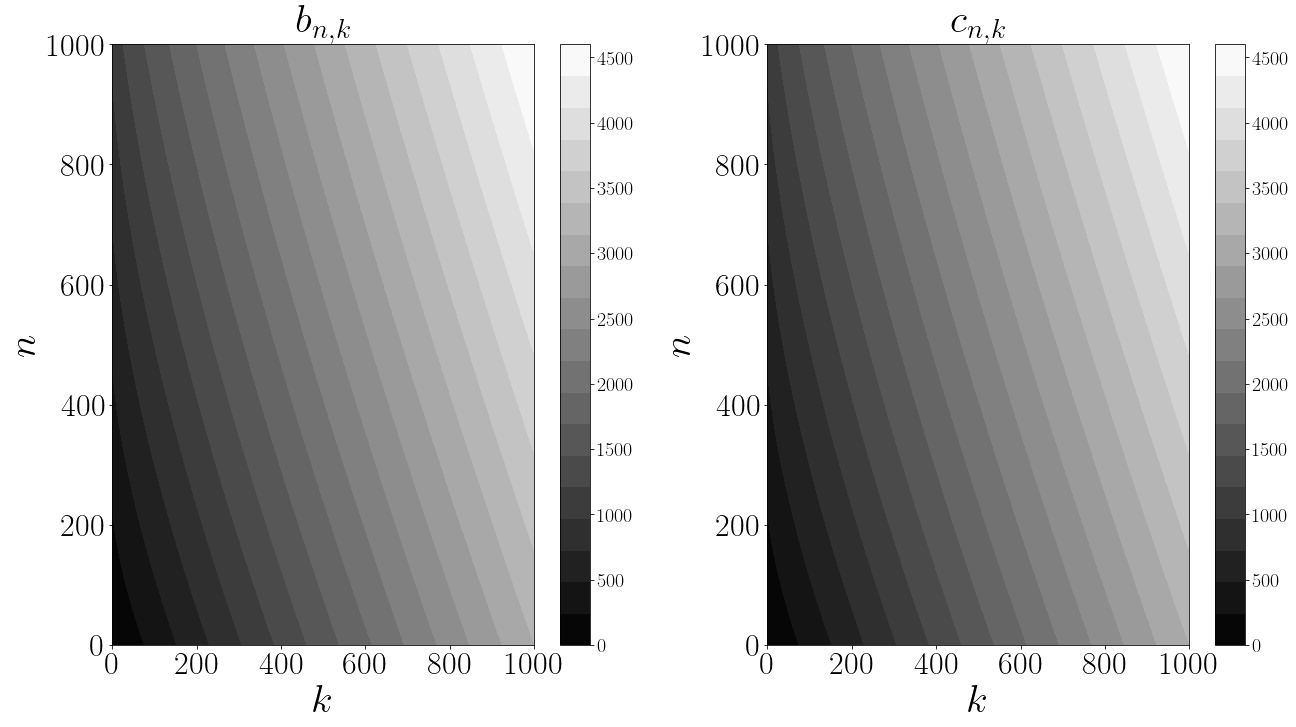

In [7]:
# root distribution of xn and yn
mat_contents = loadmat('xn.mat')
xn = mat_contents['xn']
mat_contents = loadmat('yn.mat')
yn = mat_contents['yn']
an = np.real(xn)
bn = np.imag(xn)
cn = np.imag(yn)

fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
cs = ax1.contourf(bn, levels=np.linspace(0, 4600, 20), cmap=plt.cm.gray)
# cs2 = ax1.contour(cs, levels=np.linspace(0, 4500, 10), colors='k')
# ax1.clabel(cs2, cs2.levels, fmt='%d', fontsize=fontsize*0.5, colors='k')
cbar = fig.colorbar(cs, ax=ax1, shrink=1, ticks=np.linspace(0, 4500, 10))
# cbar.add_lines(cs2)
cbar.ax.tick_params(labelsize=fontsize*0.5)
ax1.set_title('$b_{n,k}$', size=fontsize)
ax1.set_xlabel('$k$', size=fontsize)
ax1.set_ylabel('$n$', size=fontsize)
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)

cs = ax2.contourf(cn, levels=np.linspace(0, 4600, 20), cmap=plt.cm.gray)
# cs2 = ax2.contour(cs, levels=np.linspace(0, 4500, 10), colors='k')
cbar = fig.colorbar(cs, ax=ax2, shrink=1, ticks=np.linspace(0, 4500, 10))
# cbar.add_lines(cs2)
cbar.ax.tick_params(labelsize=fontsize*0.5)
ax2.set_title('$c_{n,k}$', size=fontsize)
ax2.set_xlabel('$k$', size=fontsize)
ax2.set_ylabel('$n$', size=fontsize)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()



In [11]:
# check convergence1 with b

# get data 1
dir_name1 = 'test_L_ds'
dir_name2 = 'err_b'
t_dir = os.path.join(PWD, dir_name1, dir_name2)
mat_list = glob.glob('%s/case2_L*_ds*_check_b*_u.mat' % t_dir)

b_list = []        # location of x_f
errx_b = []          # error of velocity
erry_b = []          # error of velocity
errz_b = []          # error of velocity
errx1_b = []          # error of velocity
erry1_b = []          # error of velocity
errz1_b = []          # error of velocity

for mati in mat_list:
    mat_contents = loadmat(mati)
    kwargs = mat_contents['kwargs'][0, 0]
    Li, dsi, bi = scanf('case2_L%f_ds%f_check_b%f_u.mat', os.path.basename(mati))
    u11_ana = mat_contents['u11_ana']
    u21_ana = mat_contents['u21_ana']
    u31_ana = mat_contents['u31_ana']
    u11_num = mat_contents['u11_num']
    u21_num = mat_contents['u21_num']
    u31_num = mat_contents['u31_num']
    ni = u11_ana.size
    errxi = np.linalg.norm(u11_ana - u11_num) / ni
    erryi = np.linalg.norm(u21_ana - u21_num) / ni
    errzi = np.linalg.norm(u31_ana - u31_num) / ni
    errxi1 = np.sqrt(np.sum((u11_ana - u11_num) ** 2) / np.sum(u11_ana ** 2)) / ni
    erryi1 = np.sqrt(np.sum((u21_ana - u21_num) ** 2) / np.sum(u21_ana ** 2)) / ni
    errzi1 = np.sqrt(np.sum((u31_ana - u31_num) ** 2) / np.sum(u31_ana ** 2)) / ni
    
    b_list.append(bi)
    errx_b.append(errxi)
    erry_b.append(erryi)
    errz_b.append(errzi)
    errx1_b.append(errxi1)
    erry1_b.append(erryi1)
    errz1_b.append(errzi1)
    
data_err_b = pd.DataFrame({'b': np.hstack(b_list), 
                         'errx_b': np.hstack(errx_b), 
                         'erry_b': np.hstack(erry_b), 
                         'errz_b': np.hstack(errz_b), 
                         'errx1_b': np.hstack(errx1_b), 
                         'erry1_b': np.hstack(erry1_b), 
                         'errz1_b': np.hstack(errz1_b), })\
               .pivot_table(index=['b'])
errx_b = data_err_b.errx_b
erry_b = data_err_b.erry_b
errz_b = data_err_b.errz_b
errx1_b = data_err_b.errx1_b
erry1_b = data_err_b.erry1_b
errz1_b = data_err_b.errz1_b


In [12]:
# check convergence of sphere
dir_name1 = 'sphereTest'
t_dir = os.path.join(PWD, dir_name1)
txt_names = glob.glob('%s/*.txt' % t_dir)

epsilon = []
nnode = []
resistance = []
rs = []

for txt_name in txt_names:
    with open(txt_name, 'r') as ftxt:
        FILE_DATA = ftxt.read()
    
    text_headle = 'force nodes'
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    nnode.append(temp1)
    
    text_headle = 'epsilon: '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    epsilon.append(temp1)
    
    text_headle = 'sphere radius: '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    rs.append(temp1)
    
    text_headle = 'Resultant at z axis is \[ '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=3)
    resistance.append(temp1)

resistance = np.vstack(resistance).T
data_sphereInPipe = pd.DataFrame({'epsilon': np.hstack(epsilon), 
                    'nnode': np.hstack(nnode), 
                    'rs': np.hstack(rs), 
                    'Fx': resistance[0], 
                    'Fy': resistance[1], 
                    'Fz': resistance[2]})\
        .pivot_table(index=['nnode', 'epsilon'], columns=['rs'])

resFz = data_sphereInPipe.Fz

y = 0.000232 + 0.000001 * x in range (0, 50000)


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


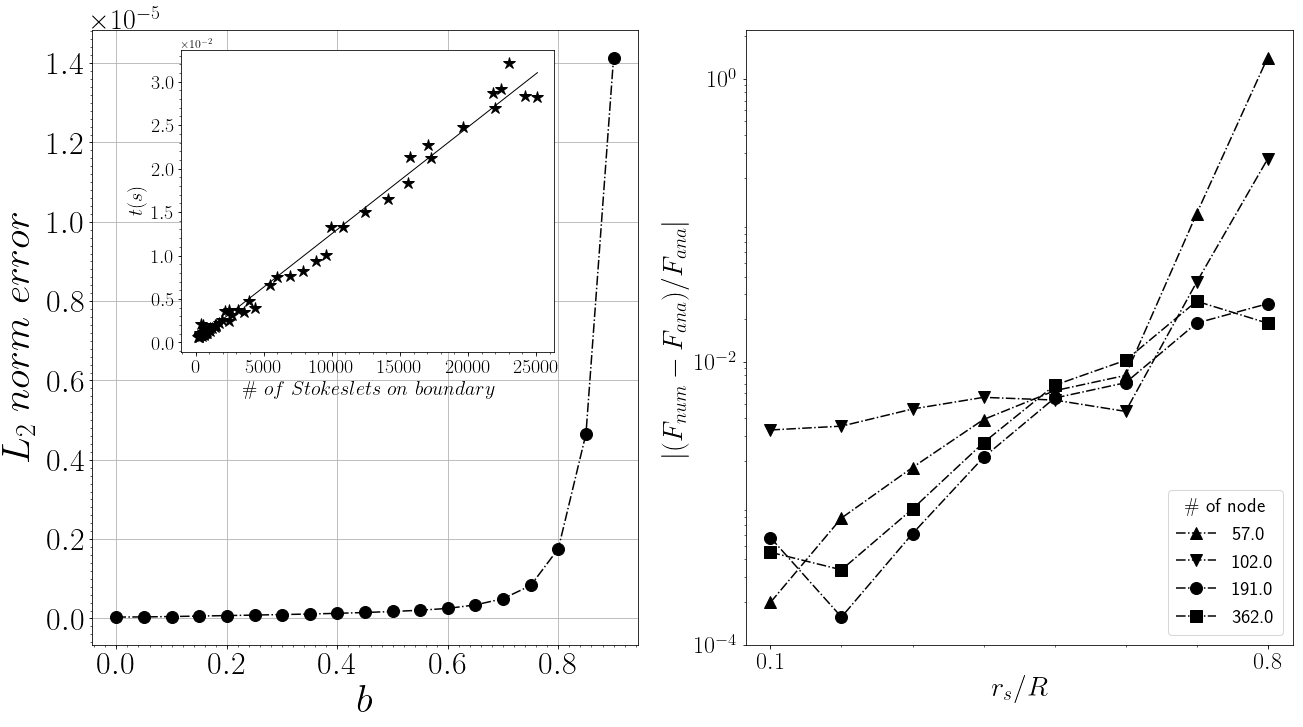

In [13]:
# err-vs
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax4 = plt.axes([.147, .515, .28, .4])

ax1.plot(errx_b.index, double(errx_b.values), 'ko-.', ms=fontsize*0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax1.set_xlabel('$b$', size=fontsize)
ax1.yaxis.get_offset_text().set_fontsize(fontsize*0.7)
ax1.xaxis.set_minor_locator(MultipleLocator(0.02))
ax1.yaxis.set_minor_locator(MultipleLocator(0.0000002))
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='major')

mat_contents = loadmat('num_ana_speed.mat')
dt_num = mat_contents['dt_num'].T[0] * 24 / 1000 # 24 cores, 1000 nodes. 
nnode = mat_contents['nnode'].T[0]
ax4.plot(nnode, double(dt_num), 'k*', ms=fontsize*0.3)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
spf.fit_line(ax4, nnode, dt_num, 0, 50000, ifprint=1, linestyle='-', linewidth=1)
ax4.set_ylabel('$t(s)$', size=fontsize*0.5)
ax4.set_xlabel('$\#\ of\ Stokeslets\ on\ boundary$', size=fontsize*0.5)
ax4.yaxis.get_offset_text().set_fontsize(fontsize*0.3)
ax4.xaxis.set_minor_locator(MultipleLocator(1000))
ax4.yaxis.set_minor_locator(MultipleLocator(0.001))
plt.sca(ax4)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)
# plt.grid(True, which='major')

ana_rs = np.arange(0, 0.9, 0.1)
ana_Fz = np.array([1.000, 1.263, 1.680, 2.371, 3.596, 5.970, 11.135, 24.955, 73.555])
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'd-.', '<-.', '>-.']
es = resFz.index.levels[1][[2]]
for nnode, lsi in zip(resFz.index.levels[0][[0, 1, 2, 3]], linestyle_list):
#     for nnode in resFz.index.levels[0]:
    tx = resFz.loc[nnode].loc[es]
    ty = tx.columns.values
    ax2.plot(ty, np.abs((tx.values[0] - ana_Fz[1:])/ana_Fz[1:]), lsi, label=nnode, ms=fontsize*0.3, color='k')
ax2.set_yscale('log')
ax2.xaxis.set_ticks(np.array((0.1, 0.8)))
ax2.xaxis.set_minor_locator(MultipleLocator(1e-1))
ax2.yaxis.set_ticks(np.array((10**-4, 10**-2, 10**0)))
ax2.legend(loc=4, fontsize=fontsize*0.5)
ax2.get_legend().set_title('\# of node', prop = {'size':fontsize*0.5})
ax2.set_xlabel('$r_s/R$', fontsize=fontsize*0.7)
ax2.set_ylabel('$|(F_{num}-F_{ana})/F_{ana}|$', fontsize=fontsize*0.7)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.6)
plt.yticks(fontsize=fontsize*0.6)
plt.tight_layout()



y = 0.000232 + 0.000001 * x in range (0, 50000)


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


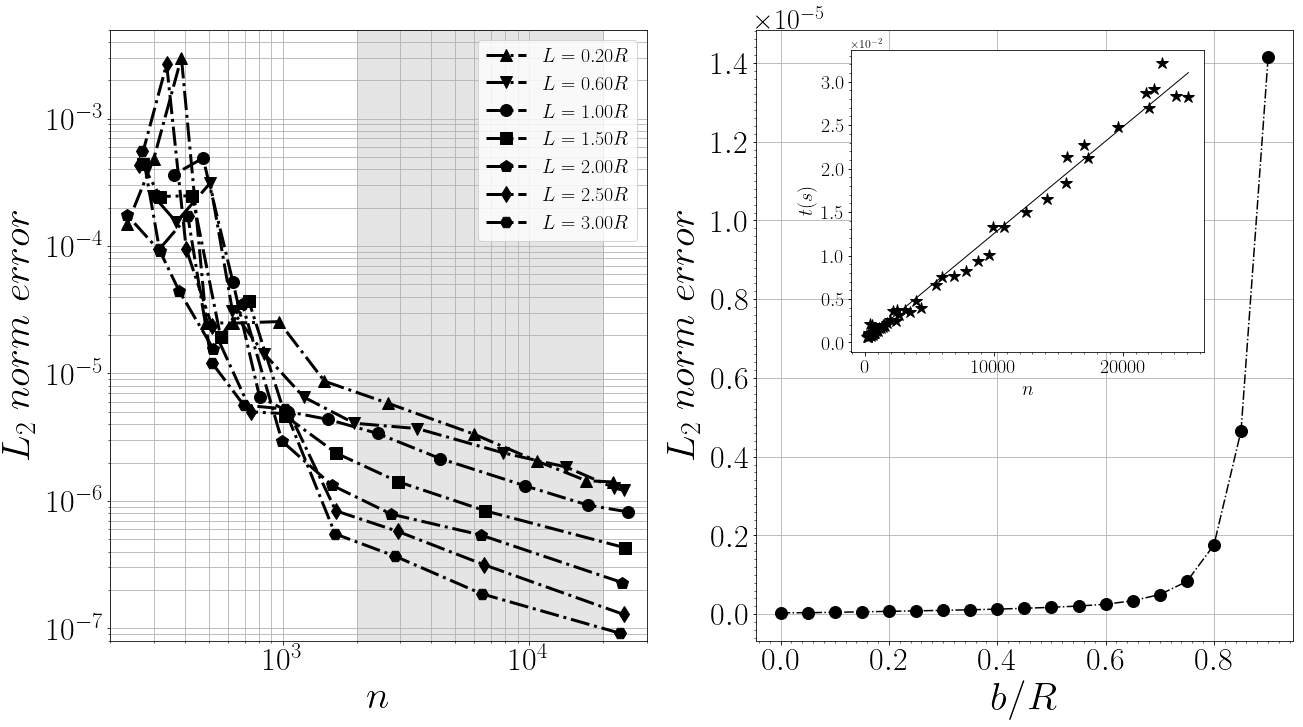

In [14]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 2)
ax2 = fig.add_subplot(1, 2, 1)
ax4 = plt.axes([.65, .515, .265, .4])

ax1.plot(errx_b.index, double(errx_b.values), 'ko-.', ms=fontsize*0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax1.set_xlabel('$b/R$', size=fontsize)
ax1.yaxis.get_offset_text().set_fontsize(fontsize*0.7)
ax1.xaxis.set_minor_locator(MultipleLocator(0.02))
ax1.yaxis.set_minor_locator(MultipleLocator(0.0000002))
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='major')

mat_contents = loadmat('num_ana_speed.mat')
dt_num = mat_contents['dt_num'].T[0] * 24 / 1000 # 24 cores, 1000 nodes. 
nnode = mat_contents['nnode'].T[0]
ax4.plot(nnode, double(dt_num), 'k*', ms=fontsize*0.3)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
spf.fit_line(ax4, nnode, dt_num, 0, 50000, ifprint=1, linestyle='-', linewidth=1)
ax4.set_ylabel('$t(s)$', size=fontsize*0.5)
ax4.set_xlabel('$n$', size=fontsize*0.5)
ax4.yaxis.get_offset_text().set_fontsize(fontsize*0.3)
ax4.xaxis.set_minor_locator(MultipleLocator(1000))
ax4.yaxis.set_minor_locator(MultipleLocator(0.001))
plt.sca(ax4)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)

# 1/ds-err
bi = errx.columns[[5]].values
t0 = errx[bi]
t1 = errx1[bi]
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'p-.', 'd-.', 'H-.']
for Li, lsi in zip(t1.index.levels[0], linestyle_list):
    ty = t0.loc[Li]
#     tx = 1 / ty.index
    tx = data_detail.loc[Li].nnode.values
    ty = t0.loc[Li].values.T[0]
    ty1 = t1.loc[Li].values.T[0]
    ax2.loglog(tx, ty, lsi, label='$L=%.2fR$' % Li, linewidth=3, ms=fontsize*0.3, color='k')
#     ax3.loglog(tx, ty1, '*-.', label='L=%.2f' % Li, linewidth=3)
#     spf.fit_power_law(ax2, tx, ty, 13, 35, linestyle='-', linewidth=5)
ax2.legend(fontsize=fontsize*0.5, loc=0)
ax2.set_xlabel('$n$', size=fontsize)
ax2.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax2.set_xlim(2e2, 3e4)
# # ax2.set_ylim(1e-2, 1e2)
# # ax2.loglog((15, 40), (1e-5, 10**((np.log10(15 / 40))*1.3 + np.log10(1e-5))), 'k-', linewidth=5)
# # ax2.loglog((13, 35), (2e-6, 10**((np.log10(13 / 35))*1.3 + np.log10(2e-6))), 'k-', linewidth=5)
# xticks = np.array([2e2, 1e3, 1e4, 3e4])
# ax2.xaxis.set_ticks(xticks)
# ax2.xaxis.set_ticklabels(xticks)
tylim = (8e-8, 0.005)
ax2.fill_between(np.array((2000, 20000)), *tylim, color='k', alpha=0.1)
ax2.set_ylim(tylim)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()


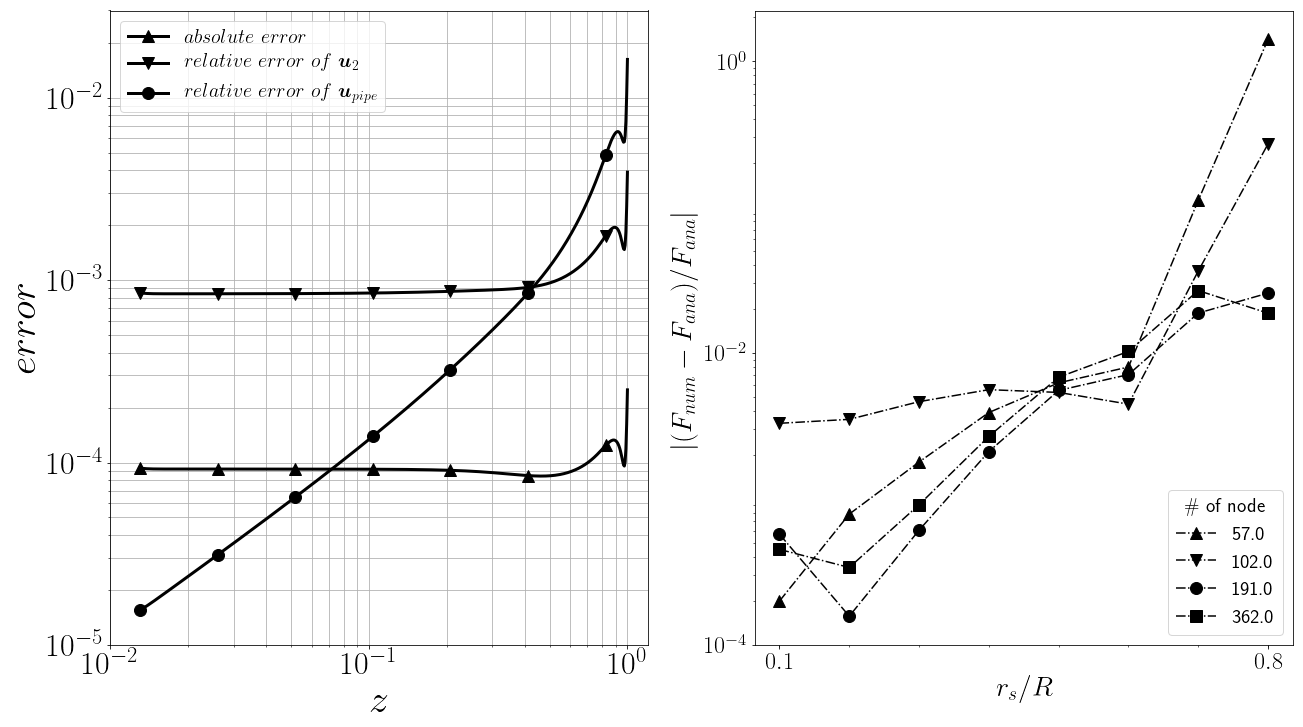

In [16]:
# err-vs
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

rel_err1 = np.abs((num_uz - uz) / uz)
rel_err2 = np.abs((num_uz - uz) / (uz - uz_inf))
rel_err3 = np.abs(num_uz - uz)
# rel_err = np.abs((num_uz - uz) / uz)
# rel_err2 = np.abs((num_uz - uz))
# rel_err2 = np.abs(uz - uz_inf)

ax1.loglog(z1, rel_err3, '^-', linewidth=3, label='$absolute\ error$', color='k', ms=fontsize*0.3, markevery=100)
ax1.loglog(z1, rel_err2, 'v-', linewidth=3, label='$relative\ error\ of\ \\bm{u}_{2}', color='k', ms=fontsize*0.3, markevery=100)
ax1.loglog(z1, rel_err1, 'o-', linewidth=3, label='$relative\ error\ of\ \\bm{u}_{pipe}$', color='k', ms=fontsize*0.3, markevery=100)
ax1.legend(fontsize=fontsize*0.5, loc=2)
ax1.set_xlabel('$z$', size=fontsize)
ax1.set_ylabel('$error$', size=fontsize)
ax1.set_xlim(0.01, 1.2)
ax1.set_ylim(1e-5, 3e-2)
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()


ana_rs = np.arange(0, 0.9, 0.1)
ana_Fz = np.array([1.000, 1.263, 1.680, 2.371, 3.596, 5.970, 11.135, 24.955, 73.555])
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'd-.', '<-.', '>-.']
es = resFz.index.levels[1][[2]]
for nnode, lsi in zip(resFz.index.levels[0][[0, 1, 2, 3]], linestyle_list):
#     for nnode in resFz.index.levels[0]:
    tx = resFz.loc[nnode].loc[es]
    ty = tx.columns.values
    ax2.plot(ty, np.abs((tx.values[0] - ana_Fz[1:])/ana_Fz[1:]), lsi, label=nnode, ms=fontsize*0.3, color='k')
ax2.set_yscale('log')
ax2.xaxis.set_ticks(np.array((0.1, 0.8)))
ax2.xaxis.set_minor_locator(MultipleLocator(1e-1))
ax2.yaxis.set_ticks(np.array((10**-4, 10**-2, 10**0)))
ax2.legend(loc=4, fontsize=fontsize*0.5)
ax2.get_legend().set_title('\# of node', prop = {'size':fontsize*0.5})
ax2.set_xlabel('$r_s/R$', fontsize=fontsize*0.7)
ax2.set_ylabel('$|(F_{num}-F_{ana})/F_{ana}|$', fontsize=fontsize*0.7)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.6)
plt.yticks(fontsize=fontsize*0.6)
plt.tight_layout()



In [98]:
# check convergence1

# get data 1
dir_name1 = 'test_L_ds'
dir_name2 = 'case3'
t_dir = os.path.join(PWD, dir_name1, dir_name2)
mat_list = glob.glob('%s/case?_L*_ds*_check_b*_u.mat' % t_dir)

L = []             # pipe length
ds = []            # delta length
b_list = []        # location of x_f
threshold = []     # cut of threshold
errx = []          # error of velocity
erry = []          # error of velocity
errz = []          # error of velocity
errx1 = []          # error of velocity
erry1 = []          # error of velocity
errz1 = []          # error of velocity
nnode = []         # amount of nodes

for mati in mat_list:
    mat_contents = loadmat(mati)
    kwargs = mat_contents['kwargs'][0, 0]
    _, Li, dsi, bi = scanf('case%d_L%f_ds%f_check_b%f_u.mat', os.path.basename(mati))
    cthi = kwargs['th'][0]
    u11_ana = mat_contents['u11_ana']
    u21_ana = mat_contents['u21_ana']
    u31_ana = mat_contents['u31_ana']
    u11_num = mat_contents['u11_num']
    u21_num = mat_contents['u21_num']
    u31_num = mat_contents['u31_num']
    t_nodes = mat_contents['nodes']
    ni = u11_ana.size
    errxi = np.linalg.norm(u11_ana - u11_num) / ni
    erryi = np.linalg.norm(u21_ana - u21_num) / ni
    errzi = np.linalg.norm(u31_ana - u31_num) / ni
    
    idx = np.isclose(np.linalg.norm(t_nodes[:, :2], axis=1), 1)
    idx = np.abs(t_nodes[:, 2]) < 0.5
    tmp = np.sort(np.linalg.norm(u11_ana.reshape(-1, 3) - u11_num.reshape(-1, 3), axis=1)[idx])
    errxi1 = np.linalg.norm(tmp[:])
    tmp = np.sort(np.linalg.norm(u21_ana.reshape(-1, 3) - u21_num.reshape(-1, 3), axis=1)[idx])
    erryi1 = np.linalg.norm(tmp[:])
    tmp = np.sort(np.linalg.norm(u31_ana.reshape(-1, 3) - u31_num.reshape(-1, 3), axis=1)[idx])
    errzi1 = np.linalg.norm(tmp[:])
        
    L.append(Li)
    ds.append(dsi)
    b_list.append(bi)
    threshold.append(cthi)
    errx.append(errxi)
    erry.append(erryi)
    errz.append(errzi)
    errx1.append(errxi1)
    erry1.append(erryi1)
    errz1.append(errzi1)
    
data_err = pd.DataFrame({'L': np.hstack(L), 
                         'ds': np.hstack(ds), 
                         'b': np.hstack(b_list), 
                         'cth': np.hstack(threshold),
                         'errx': np.hstack(errx), 
                         'erry': np.hstack(erry), 
                         'errz': np.hstack(errz), 
                         'errx1': np.hstack(errx1), 
                         'erry1': np.hstack(erry1), 
                         'errz1': np.hstack(errz1), })\
               .pivot_table(index=['L', 'ds'], columns=['b'])
errx = data_err.errx
erry = data_err.erry
errz = data_err.errz
errx1 = data_err.errx1
erry1 = data_err.erry1
errz1 = data_err.errz1

# get data 2
txt_names = glob.glob('%s/*.txt' % t_dir)
L = []             # pipe length
ds = []            # delta length
nnode = []         # amount of nodes
threshold = []     # cut of threshold

for txt_name in txt_names:
    with open(txt_name, 'r') as ftxt:
        FILE_DATA = ftxt.read()
    
    text_headle = 'pipe length:'
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    L.append(temp1)
    
    text_headle = 'delta length, epsilon and factor of pipe are'
    temp2 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    ds.append(temp2)
    
    text_headle = 'Stokeslets in pipe prepare, contain '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    nnode.append(temp1)
    
    text_headle = 'threshold of series is '
    temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
    threshold.append(temp1)

data_detail = pd.DataFrame({'L': np.hstack(L), 
                    'ds': np.hstack(ds), 
                    'nnode': np.hstack(nnode), 
                    'cth': np.hstack(threshold), })\
        .pivot_table(index=['L', 'ds'])
nnode = data_detail.nnode


y = 0.000232 + 0.000001 * x in range (0, 50000)


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


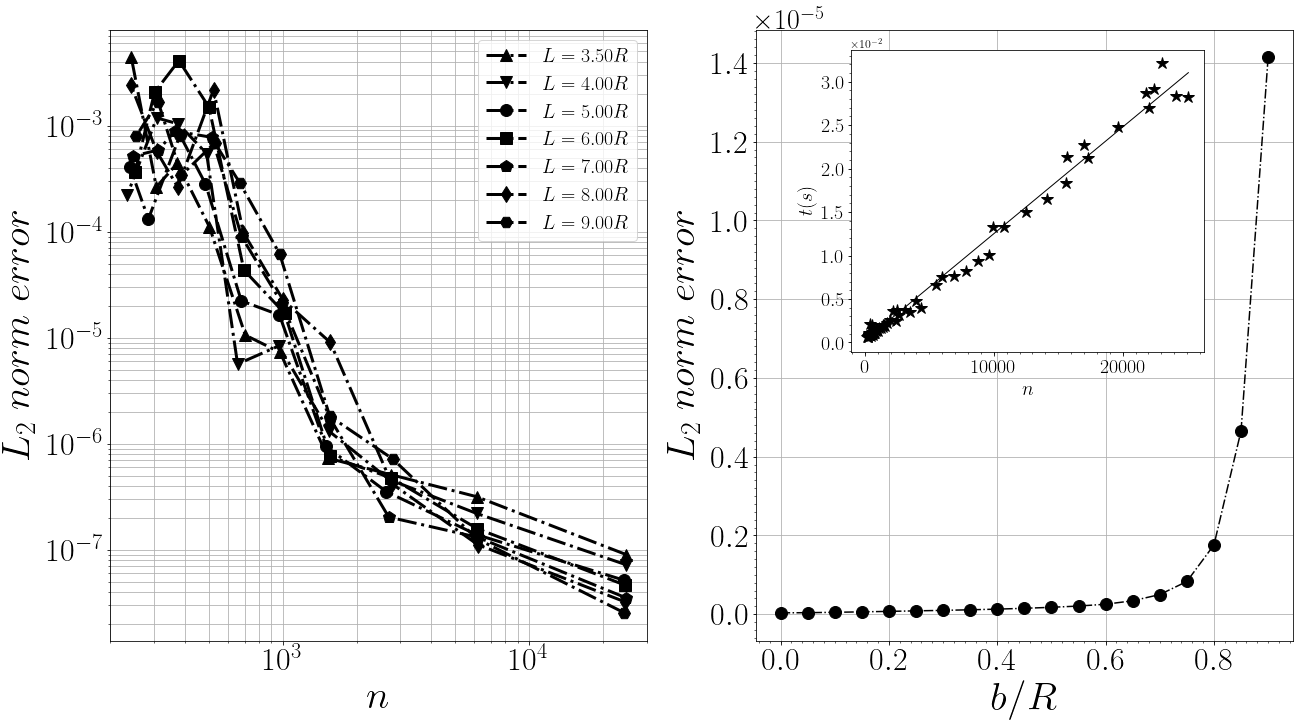

In [101]:
fig = plt.figure()
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 2)
ax2 = fig.add_subplot(1, 2, 1)
ax4 = plt.axes([.65, .515, .265, .4])

ax1.plot(errx_b.index, double(errx_b.values), 'ko-.', ms=fontsize*0.3)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax1.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax1.set_xlabel('$b/R$', size=fontsize)
ax1.yaxis.get_offset_text().set_fontsize(fontsize*0.7)
ax1.xaxis.set_minor_locator(MultipleLocator(0.02))
ax1.yaxis.set_minor_locator(MultipleLocator(0.0000002))
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='major')

mat_contents = loadmat('num_ana_speed.mat')
dt_num = mat_contents['dt_num'].T[0] * 24 / 1000 # 24 cores, 1000 nodes. 
nnode = mat_contents['nnode'].T[0]
ax4.plot(nnode, double(dt_num), 'k*', ms=fontsize*0.3)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
spf.fit_line(ax4, nnode, dt_num, 0, 50000, ifprint=1, linestyle='-', linewidth=1)
ax4.set_ylabel('$t(s)$', size=fontsize*0.5)
ax4.set_xlabel('$n$', size=fontsize*0.5)
ax4.yaxis.get_offset_text().set_fontsize(fontsize*0.3)
ax4.xaxis.set_minor_locator(MultipleLocator(1000))
ax4.yaxis.set_minor_locator(MultipleLocator(0.001))
plt.sca(ax4)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)

# 1/ds-err
bi = errx.columns[[5]].values
t0 = errx[bi]
t1 = errz1[bi]
linestyle_list = ['^-.', 'v-.', 'o-.', 's-.', 'p-.', 'd-.', 'H-.']
for Li, lsi in zip(t1.index.levels[0], linestyle_list):
    ty = t0.loc[Li]
#     tx = 1 / ty.index
    tx = data_detail.loc[Li].nnode.values
    ty = t0.loc[Li].values.T[0]
    ty1 = t1.loc[Li].values.T[0]
    ax2.loglog(tx, ty, lsi, label='$L=%.2fR$' % Li, linewidth=3, ms=fontsize*0.3, color='k')
#     ax2.loglog(tx, ty1, lsi, label='$L=%.2fR$' % Li, linewidth=3, ms=fontsize*0.3, color='k')
#     spf.fit_power_law(ax2, tx, ty, 13, 35, linestyle='-', linewidth=5)
ax2.legend(fontsize=fontsize*0.5, loc=0)
ax2.set_xlabel('$n$', size=fontsize)
ax2.set_ylabel('$L_2\ norm\ error$', size=fontsize)
ax2.set_xlim(2e2, 3e4)
# # ax2.set_ylim(1e-2, 1e2)
# # ax2.loglog((15, 40), (1e-5, 10**((np.log10(15 / 40))*1.3 + np.log10(1e-5))), 'k-', linewidth=5)
# # ax2.loglog((13, 35), (2e-6, 10**((np.log10(13 / 35))*1.3 + np.log10(2e-6))), 'k-', linewidth=5)
# xticks = np.array([2e2, 1e3, 1e4, 3e4])
# ax2.xaxis.set_ticks(xticks)
# ax2.xaxis.set_ticklabels(xticks)
tylim = (8e-8, 0.005)
# ax2.fill_between(np.array((2000, 20000)), *tylim, color='k', alpha=0.1)
# ax2.set_ylim(tylim)
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.grid(True, which='both')
plt.tight_layout()


In [97]:
errx

b                    0.0           0.1           0.2           0.3  \
L    ds                                                              
3.5  0.037  8.659165e-08  8.600475e-08  8.740054e-08  8.917139e-08   
     0.074  1.726425e-07  1.824874e-07  2.056214e-07  2.334737e-07   
     0.111  2.908843e-07  3.069363e-07  3.310976e-07  3.681287e-07   
     0.148  8.695704e-07  6.756569e-07  7.738467e-07  7.974535e-07   
     0.185  5.211213e-06  2.108627e-06  1.621072e-06  2.136780e-06   
     0.222  1.784032e-06  1.801173e-06  5.882543e-06  1.293162e-05   
     0.259  2.058423e-06  1.048765e-05  1.763015e-05  2.638511e-05   
     0.296  2.988926e-05  2.806271e-05  1.777115e-05  2.319392e-05   
     0.333  1.754123e-05  1.534688e-05  1.528098e-05  4.377978e-05   
     0.370  4.472551e-06  3.133396e-04  6.317081e-04  1.437435e-03   
4.0  0.039  4.945442e-08  5.058923e-08  5.566376e-08  6.201386e-08   
     0.078  1.248642e-07  1.299263e-07  1.428186e-07  1.620345e-07   
     0.117  2.216788e-07  2.369336e-07  2.776133e-07  3.334386e-07   
     0.156  4.652703e-07  4.310552e-07  5.764526e-07  7.404666e-07   
     0.195  9.265404e-07  9.395735e-07  1.541191e-06  2.945310e-06   
     0.234  8.620694e-07  1.403417e-06  4.025876e-06  3.190478e-06   
     0.273  8.554922e-06  6.487783e-06  7.978576e-06  1.063908e-05   
     0.312  1.348543e-04  2.487734e-04  2.991848e-05  2.824973e-05   
     0.351  6.647186e-05  5.501044e-05  7.569018e-05  1.521131e-04   
     0.390  3.246966e-06  1.025184e-05  2.269581e-05  5.036408e-05   
5.0  0.043  2.716165e-08  2.946129e-08  3.484118e-08  4.129400e-08   
     0.086  6.471478e-08  7.164845e-08  8.535980e-08  1.023665e-07   
     0.129  1.235027e-07  1.698521e-07  2.077975e-07  2.586055e-07   
     0.172  2.476559e-07  2.723473e-07  3.721982e-07  4.943527e-07   
     0.215  1.926819e-06  2.853608e-06  5.514267e-06  9.963082e-06   
     0.258  8.378060e-06  8.859004e-06  1.006811e-05  1.231807e-05   
     0.301  1.116197e-05  9.812255e-06  1.316669e-05  5.842033e-06   
     0.344  4.052032e-05  5.729423e-05  2.205329e-05  8.534504e-05   
     0.387  2.593833e-06  4.046075e-06  1.099294e-05  2.814268e-05   
     0.430  1.009647e-05  2.687005e-05  6.299014e-05  1.255188e-04   
...                  ...           ...           ...           ...   
8.0  0.052  9.044802e-09  1.201623e-08  1.719226e-08  2.267456e-08   
     0.104  2.527688e-08  3.666427e-08  5.215578e-08  7.210251e-08   
     0.156  1.855600e-07  1.309059e-07  2.117769e-07  3.001105e-07   
     0.208  3.313752e-07  9.178656e-07  1.126802e-06  2.061097e-06   
     0.260  2.763098e-06  5.414166e-06  3.428662e-06  6.370078e-06   
     0.312  4.123839e-05  3.512467e-05  4.178276e-05  2.814835e-05   
     0.364  5.195478e-05  4.488642e-05  2.238506e-05  1.976711e-04   
     0.416  2.125660e-06  8.259042e-06  2.473357e-05  6.019707e-05   
     0.468  4.053648e-05  5.951644e-05  1.096305e-04  1.964553e-04   
     0.520  9.793374e-05  2.873469e-04  5.969180e-04  9.897096e-04   
9.0  0.055  6.886527e-09  9.388254e-09  1.368485e-08  1.803147e-08   
     0.110  2.138559e-08  3.415219e-08  5.576695e-08  7.783626e-08   
     0.165  2.174180e-07  1.800168e-07  2.999016e-07  4.007666e-07   
     0.220  3.404826e-07  2.488059e-07  3.152139e-07  3.670524e-07   
     0.275  1.142442e-05  2.413792e-06  7.928016e-06  2.395259e-05   
     0.330  1.139415e-05  1.135063e-05  8.948111e-06  2.098923e-05   
     0.385  2.107803e-05  1.393420e-05  2.103383e-05  8.593623e-05   
     0.440  1.279772e-06  1.592465e-05  4.134727e-05  8.907188e-05   
     0.495  8.472820e-05  1.354910e-04  2.742175e-04  5.586066e-04   
     0.550  1.219073e-04  1.409254e-04  1.937761e-04  3.220940e-04   
10.0 0.058  5.533202e-09  8.035242e-09  1.220201e-08  1.650897e-08   
     0.116  2.984171e-08  2.553066e-08  3.555964e-08  4.779991e-08   
     0.174  1.103116e-07  1.292019e-07  1.653562e-07  2.183993e-07   
     0.232  1.932187e-07  3.828457e-07  1.225243e-06  2.993715e-06   
     0.290